In [192]:
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torchvision
import torch
from torchsummary import summary
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Data preparation

In [193]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [194]:
class SimpsonsDataset(Dataset):
    """
    DataLoader that scales picture and turns it into torch tensor
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if (self.mode != 'test'):
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        if (self.mode == 'train'):
            transform = transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if (self.mode == 'test'):
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [195]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

In [196]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [197]:
val_dataset = SimpsonsDataset(val_files, mode='val')

## Basis functions

In [198]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # formal part
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # batch step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        # history 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [199]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # formal part
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # prediction 
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        # history 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [200]:
def train(train_files, val_files, model, epochs, batch_size, 
          scheduler, optimizer, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    best_score = 0
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            # train
            train_loss, train_acc = fit_epoch(model, train_loader, criterion,\
                                              optimizer, scheduler)
            print("loss", train_loss)
            # validation
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            # save best
            if (epoch > 15 and val_acc > best_score + 0.003):
                torch.save(model, 'ft_model.pt')
            # info output 
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [201]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Model extraction

In [202]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
#model = torchvision.models.resnet18(pretrained=True)

Using cache found in C:\Users\Nikita/.cache\torch\hub\pytorch_vision_v0.10.0


In [203]:
i = 0
for child in model.children():
    print('Child number ', i)
    print(child)
    i+=1

Child number  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child number  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child number  2
ReLU(inplace=True)
Child number  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child number  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

In [204]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Fine tuning

In [205]:
n_classes = len(np.unique(train_val_labels))

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,n_classes)

In [206]:
child_counter = 0
for child in model.children():
    if child_counter <= 6:
        for param in child.parameters():
            param.requires_grad = False
    child_counter += 1


In [207]:
# for param in model.parameters():
#     param.requires_grad = False

#layers_to_unfreeze = 14

# for param in model.features[:-layers_to_unfreeze].parameters():
#     param.requires_grad = False

In [208]:
mdl = model.to(DEVICE) 
print("we will classify :{}".format(n_classes))

we will classify :42


In [209]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

## Training

In [210]:
initial_lr, decay_step, lr_decay = 0.005, 3, 0.7

optimizer = torch.optim.AdamW(model.parameters(), lr = initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = decay_step, gamma=lr_decay)
criterion = nn.CrossEntropyLoss()

In [211]:
history = train(train_dataset, val_dataset, model=mdl, epochs=25, batch_size=32, \
                scheduler = scheduler , optimizer = optimizer, criterion=criterion) 

epoch:   0%|                                                                                    | 0/25 [00:00<?, ?it/s]

loss 0.7799402399269547


epoch:   4%|██▉                                                                      | 1/25 [04:22<1:44:49, 262.05s/it]


Epoch 001 train_loss: 0.7799     val_loss 0.1791 train_acc 0.7919 val_acc 0.9524
loss 0.20659407920705736


epoch:   8%|█████▊                                                                   | 2/25 [08:39<1:39:30, 259.59s/it]


Epoch 002 train_loss: 0.2066     val_loss 0.1704 train_acc 0.9432 val_acc 0.9576
loss 0.10699066544932667


epoch:  12%|████████▊                                                                | 3/25 [13:00<1:35:19, 259.98s/it]


Epoch 003 train_loss: 0.1070     val_loss 0.2052 train_acc 0.9706 val_acc 0.9499
loss 0.041333817914238


epoch:  16%|███████████▋                                                             | 4/25 [17:21<1:31:05, 260.27s/it]


Epoch 004 train_loss: 0.0413     val_loss 0.1572 train_acc 0.9893 val_acc 0.9611
loss 0.04105842212458081


epoch:  20%|██████████████▌                                                          | 5/25 [21:41<1:26:44, 260.24s/it]


Epoch 005 train_loss: 0.0411     val_loss 0.1042 train_acc 0.9888 val_acc 0.9758
loss 0.033518871416586285


epoch:  24%|█████████████████▌                                                       | 6/25 [26:00<1:22:19, 259.96s/it]


Epoch 006 train_loss: 0.0335     val_loss 0.1236 train_acc 0.9903 val_acc 0.9735
loss 0.011187339556696412


epoch:  28%|████████████████████▍                                                    | 7/25 [30:21<1:18:05, 260.29s/it]


Epoch 007 train_loss: 0.0112     val_loss 0.1007 train_acc 0.9971 val_acc 0.9804
loss 0.014228136434962709


epoch:  32%|███████████████████████▎                                                 | 8/25 [34:42<1:13:47, 260.46s/it]


Epoch 008 train_loss: 0.0142     val_loss 0.1143 train_acc 0.9965 val_acc 0.9749
loss 0.012865158690830106


epoch:  36%|██████████████████████████▎                                              | 9/25 [39:02<1:09:27, 260.46s/it]


Epoch 009 train_loss: 0.0129     val_loss 0.1249 train_acc 0.9968 val_acc 0.9725
loss 0.0045815250073052835


epoch:  40%|████████████████████████████▊                                           | 10/25 [43:24<1:05:10, 260.69s/it]


Epoch 010 train_loss: 0.0046     val_loss 0.1055 train_acc 0.9990 val_acc 0.9794
loss 0.007674494738369834


epoch:  44%|███████████████████████████████▋                                        | 11/25 [47:45<1:00:53, 260.93s/it]


Epoch 011 train_loss: 0.0077     val_loss 0.0886 train_acc 0.9977 val_acc 0.9833
loss 0.0030495989086240884


epoch:  48%|███████████████████████████████████▌                                      | 12/25 [52:07<56:34, 261.11s/it]


Epoch 012 train_loss: 0.0030     val_loss 0.0888 train_acc 0.9993 val_acc 0.9833
loss 0.0014440369958564844


epoch:  52%|██████████████████████████████████████▍                                   | 13/25 [56:28<52:12, 261.08s/it]


Epoch 013 train_loss: 0.0014     val_loss 0.0784 train_acc 0.9995 val_acc 0.9874
loss 0.0006796014579386716


epoch:  56%|████████████████████████████████████████▎                               | 14/25 [1:00:49<47:52, 261.16s/it]


Epoch 014 train_loss: 0.0007     val_loss 0.1224 train_acc 0.9999 val_acc 0.9772
loss 0.0068922044510238


epoch:  60%|███████████████████████████████████████████▏                            | 15/25 [1:05:12<43:36, 261.68s/it]


Epoch 015 train_loss: 0.0069     val_loss 0.1089 train_acc 0.9984 val_acc 0.9827
loss 0.001817061489954653


epoch:  64%|██████████████████████████████████████████████                          | 16/25 [1:09:34<39:15, 261.77s/it]


Epoch 016 train_loss: 0.0018     val_loss 0.0977 train_acc 0.9996 val_acc 0.9843
loss 0.00047145891834487666


epoch:  68%|████████████████████████████████████████████████▉                       | 17/25 [1:13:56<34:55, 261.96s/it]


Epoch 017 train_loss: 0.0005     val_loss 0.0823 train_acc 0.9999 val_acc 0.9878
loss 0.000167136936591451


epoch:  72%|███████████████████████████████████████████████████▊                    | 18/25 [1:18:18<30:32, 261.85s/it]


Epoch 018 train_loss: 0.0002     val_loss 0.0825 train_acc 0.9999 val_acc 0.9879
loss 0.00010034776922830888


epoch:  76%|██████████████████████████████████████████████████████▋                 | 19/25 [1:22:39<26:10, 261.72s/it]


Epoch 019 train_loss: 0.0001     val_loss 0.0828 train_acc 1.0000 val_acc 0.9881
loss 9.289329395865811e-05


epoch:  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:27:01<21:48, 261.71s/it]


Epoch 020 train_loss: 0.0001     val_loss 0.0888 train_acc 1.0000 val_acc 0.9882
loss 0.0001658842882794148


epoch:  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:31:23<17:27, 261.81s/it]


Epoch 021 train_loss: 0.0002     val_loss 0.0873 train_acc 0.9999 val_acc 0.9888
loss 0.00012518540991192137


epoch:  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:35:45<13:05, 261.77s/it]


Epoch 022 train_loss: 0.0001     val_loss 0.0890 train_acc 1.0000 val_acc 0.9881
loss 0.0001250132739639361


epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:40:07<08:44, 262.01s/it]


Epoch 023 train_loss: 0.0001     val_loss 0.0884 train_acc 0.9999 val_acc 0.9883
loss 0.00010071530534153339


epoch:  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [1:44:33<04:23, 263.02s/it]


Epoch 024 train_loss: 0.0001     val_loss 0.0906 train_acc 0.9999 val_acc 0.9883
loss 6.876193609166668e-05


epoch: 100%|████████████████████████████████████████████████████████████████████████| 25/25 [1:49:08<00:00, 261.92s/it]


Epoch 025 train_loss: 0.0001     val_loss 0.0918 train_acc 1.0000 val_acc 0.9884


In [212]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = (torch.stack(val_acc)).tolist()

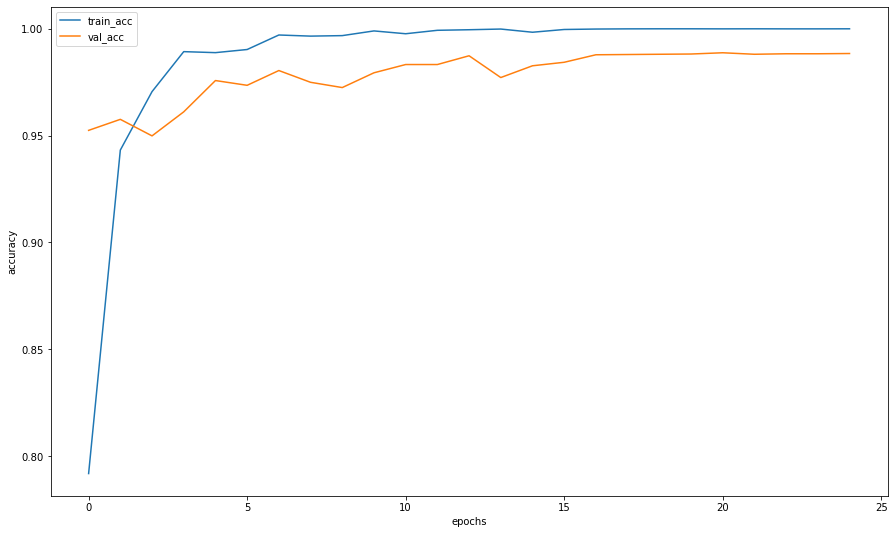

In [213]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

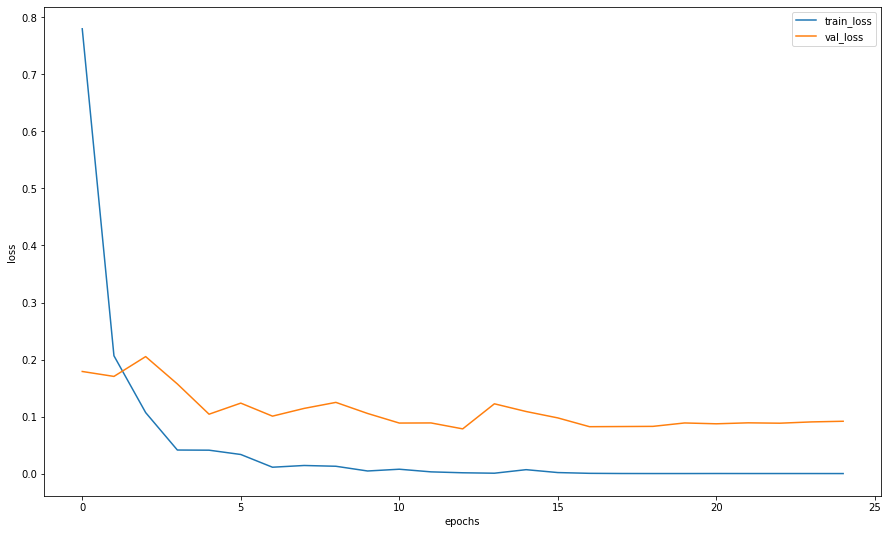

In [214]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Prediction

In [215]:
best_model = torch.load('ft_model.pt')

In [216]:
mdl = best_model

In [218]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [219]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(mdl, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [220]:
import pandas as pd
from natsort import index_natsorted
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.sort_values(
   by="Id",
   key=lambda x: np.argsort(index_natsorted(my_submit["Id"]))
)
my_submit.to_csv('submission.csv', index=False)